<a href="https://colab.research.google.com/github/tanisha1112/Laplacian-Blob-Detector/blob/main/Blob_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.stats as st
from pylab import *
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
import math

In [ ]:
def reflecting(matrix):
  n=matrix.shape[0]
  m=matrix.shape[1]
  reflect_mat = np.zeros((n,m))
  for i in range (m):
    reflect_mat[:,i]=matrix[:,m-1-i]
  return reflect_mat

def DoG(sigma):
    filter_size = 2 * int(3 * sigma + 0.5) + 1
    gaussian_filter_1 = np.zeros((filter_size, filter_size), np.float32)
    gaussian_filter_2 = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2

    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1_a = 2*np.pi*((1.414*sigma)**2)
            x2_a = np.exp(-(x**2 + y**2)/(2* (1.414*sigma)**2))
            gaussian_filter_1[x+m, y+n] = (1/x1_a)*x2_a
            x1_b = 2*np.pi*((sigma)**2)
            x2_b = np.exp(-(x**2 + y**2)/(2* (sigma)**2))
            gaussian_filter_2[x+m, y+n] = (1/x1_b)*x2_b
    return gaussian_filter_1 - gaussian_filter_2

def LoG(sigma):
  #window size
  n = np.ceil(sigma*6)
  y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
  y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
  x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
  final_filter = (-(2*sigma**2) + (x*x + y*y) ) * (x_filter*y_filter) * (1/(2*np.pi*sigma**2))
  filter_max = np.amax(final_filter)
  filter_min = np.amin(final_filter)
  plt.imshow(final_filter, cmap="gray")
  plt.show()
  return final_filter

In [ ]:
def dft(img):
  return np.fft.fft(np.fft.fft(img, axis=0), axis=1)

# def ifft(img):
#     height,width = img.shape
#     img_ifft_2d= np.fft.fft(np.conj(np.fft.fft(np.conj(img), axis=0)), axis=1)
#     return img_ifft_2d/(height * width)

def ifft(img):
  conjugate = np.conj(img)
  reconstruct = dft(conjugate)/(img.shape[0]*img.shape[1])

  return reconstruct

In [ ]:
def convolution( image, kernel):
  m,n = image.shape
  p,q = kernel.shape
  paddedKernel = np.zeros((m,n), dtype='float64')
  #paddedKernel[0:p,0:p] = kernel
  try:
      paddedKernel[int(m/2)-int(p/2):int(m/2)+int(p/2)+1, int(n/2)-int(q/2):int(n/2)+int(q/2)+1] = kernel
  except ValueError:
      paddedKernel[int(m/2)-int(p/2):int(m/2)+int(p/2), int(n/2)-int(q/2):int(n/2)+int(q/2)] = kernel
  fft_image = dft(image.astype('float64')/255.)*dft(paddedKernel.astype('float64'))
  #newImg = ifft(fft_image)
  #new_img = cv2.filter2D(image, ddepth=-1, kernel=kernel)
  new_img = np.fft.fftshift(np.absolute(ifft(fft_image)))
  return new_img

In [ ]:
def generate_scalespace(image,numscales,sigma,k):
  scalespace = []
  for i in range(numscales-1):
    sigma=sigma*k
    kernal=LoG(sigma)
    new_image = convolution(image,kernal)
    scalespace.append(np.square(np.asarray(new_image)))
  return scalespace

In [ ]:
def non_max_suppression(scalespace):

  kernel=np.ones((3,3),dtype='float64')

  scalespace_normalized=[]
  n=len(scalespace)
  for i in range(n):
    dilated = cv2.dilate(scalespace[i], kernel, iterations=1)
    THRH_2D= (np.max(scalespace[i])-np.min(scalespace[i]))*0.035
    #THRH_2D= (np.mean(scalespace[i]))
    temp = (scalespace[i]==dilated)*scalespace[i] >= THRH_2D
    scalespace_normalized.append(np.multiply(temp,scalespace[i]))
  scalespace_maxima=np.copy(scalespace_normalized)
  for i in range(n):
    lo=max(0,i-1)
    hi=min(i+1,n-1)
  #n,m=scalespcae
  #for i in range()
    scalespace_maxima[i,:,:]=np.amax(scalespace_maxima[lo:hi+1,:,:], axis=0)
  centers_bool = scalespace_maxima==scalespace_normalized
  scalespace_nms=np.multiply(scalespace_maxima,centers_bool)
  #print(scalespace_nms)
  return scalespace_nms

In [ ]:
def find_coordinates(scalespace_nms,k,sigma):
  n=len(scalespace_nms)
  for i in range(2,n):
    scale_loc = np.where(scalespace_nms[i]>0)
    # print("length of centers: ")
    # print(len(scale_loc[0]))
    scaled_sigma=sigma*k**i
    coordinates=np.zeros((3,len(scale_loc[0])))
    coordinates[0]=scale_loc[0]
    coordinates[1]=scale_loc[1]
    coordinates[2]=scaled_sigma
    coordinates=np.transpose(coordinates)
    coordinates = redundancy(coordinates, 0.01)
    if i == 2:
        final_coordinates = coordinates
    else:
        final_coordinates = np.append(final_coordinates, coordinates, axis=0)
  #final_coordinates=redundancy(coordinates, 0.9)
  print(final_coordinates.shape)
  return final_coordinates

In [ ]:
def blob_overlap( blob1, blob2):

        # radius of two blobs
        r1 = blob1[-1] * sqrt(2)
        r2 = blob2[-1] * sqrt(2)
        d = sqrt((blob1[0]-blob2[0])**2 + (blob1[1]-blob2[1])**2)

        #no overlap between two blobs
        if d > r1 + r2:
            return 0
        elif d <= abs(r1 - r2):
            return 1
        else:
            #computing the area of overlap between blobs
            ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
            ratio1 = np.clip(ratio1, -1, 1)
            acos1 = math.acos(ratio1)*2
            ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
            ratio2 = np.clip(ratio2, -1, 1)
            acos2 = math.acos(ratio2)*2
            a = -d + r2 + r1
            b = d - r2 + r1
            c = d + r2 - r1
            d = d + r2 + r1
            area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
            return area/(math.pi * (min(r1, r2) ** 2))

def redundancy(blobs_array, overlap):
        sigma = blobs_array[:, -1].max()
        distance = 2 * sigma * sqrt(2)
        # Binary search to determine all possible pairs of circles for overlap checking
        tree = spatial.cKDTree(blobs_array[:, :-1])
        pairs = np.array(list(tree.query_pairs(distance)))
        if len(pairs) == 0:
            return blobs_array
        else:
            for (i, j) in pairs:
                blob1, blob2 = blobs_array[i], blobs_array[j]

                if blob_overlap(blob1, blob2) > overlap:
                    if blob1[-1] > blob2[-1]:
                        blob2[-1] = 0
                    else:
                        blob1[-1] = 0
        return np.array([b for b in blobs_array if b[-1] > 0])

In [ ]:
def detect_blob(image, numscales=10, sigma=1.6,k=np.sqrt(2), thresh_percent=0.035):
    centers = []
    sigmas=[]
    scalespace=generate_scalespace(image,numscales,sigma,k)
    scalespace_nms=non_max_suppression(scalespace)
    final_coordinates = find_coordinates(scalespace_nms,k,sigma)
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')

    for coord in final_coordinates:

        circ = Circle((coord[1],coord[0]), coord[2], color='r', linewidth=0.5, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(final_coordinates))
    plt.show()
    return centers

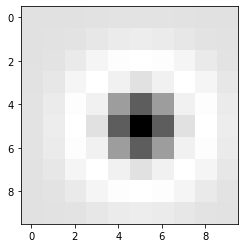

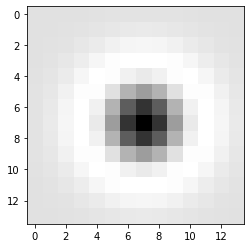

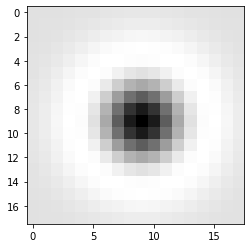

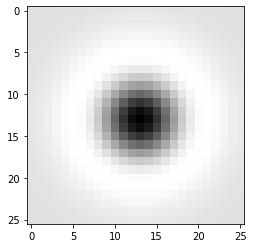

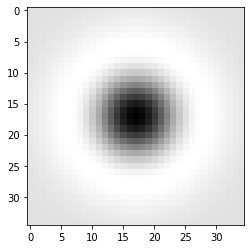

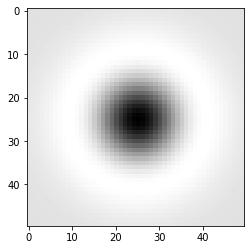

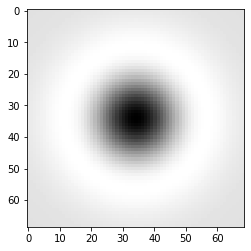

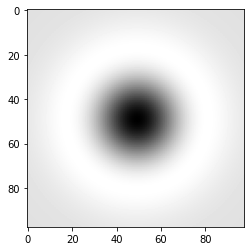

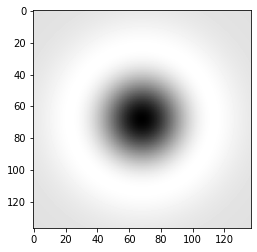

(1361, 3)


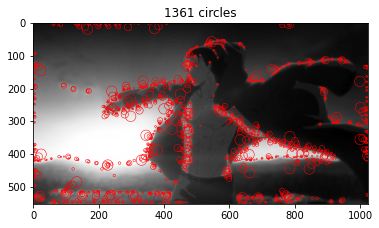

[]

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/Eren-1024x553.jpg",0)
detect_blob(img, numscales=10, sigma=1,k=np.sqrt(2), thresh_percent=0.035)

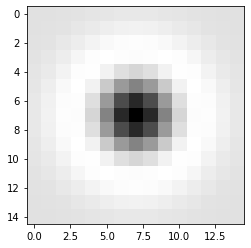

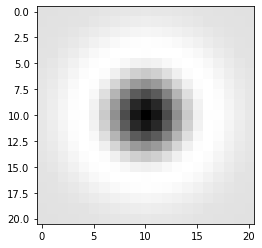

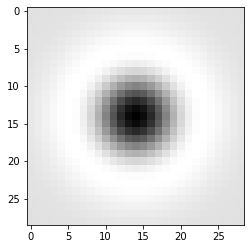

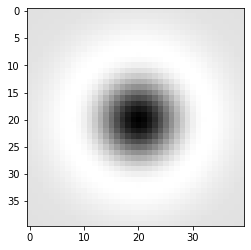

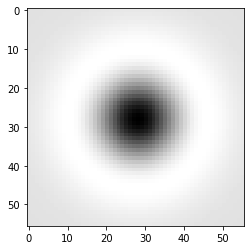

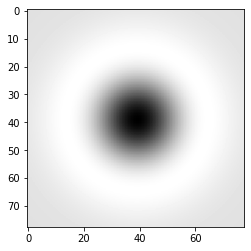

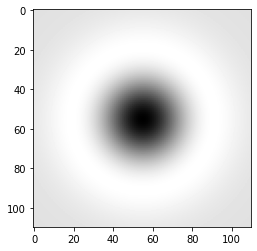

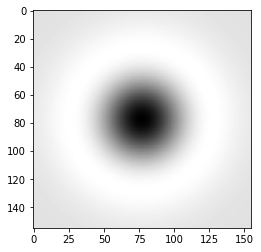

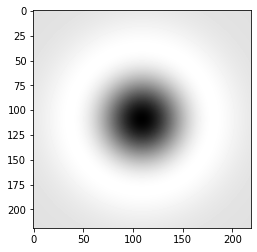

(831, 3)


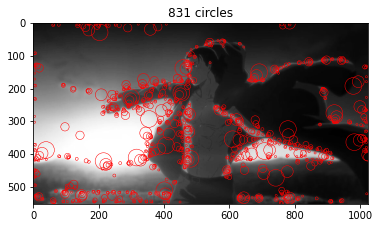

[]

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/Eren-1024x553.jpg",0)
#img=img/255
# cv2_imshow(img)
detect_blob(img, numscales=10, sigma=1.6,k=np.sqrt(2), thresh_percent=0.05)